# Project Title: 



## Aim

## Methodology

### 1. Data preparation

#### Importing Libraries

In [9]:
# Basics
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.misc import toimage
import sklearn
import time
import os
import copy
import PIL
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
from torch import Tensor
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.model_zoo import load_url
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
plt.ion() # Interactive mode
%matplotlib inline

In [10]:
# Check library versions
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(scipy.__version__))
print('pytorch: {}'.format(torch.__version__))
print('torchvision: {}'.format(torchvision.__version__))

pandas: 0.23.4
numpy: 1.14.3
matplotlib: 2.2.3
seaborn: 0.9.0
scipy: 1.0.0
pytorch: 0.4.1
torchvision: 0.2.1


### 2. Load and preview dataset

In [11]:
# Data augmentation and normalization for training data set
# Just normalization for validation data set
data_transforms = {
    'train': transforms.Compose([transforms.Resize(224), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

data_dir = './'

# Create dataset class 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','val']}
# Obtain dataset sizes for training and validation set
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
# Obtain class names
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [12]:
print(dataset_sizes, class_names)
print(image_datasets)

{'train': 11557, 'val': 2316} ['cam_b', 'cam_f', 'cam_l', 'cam_r', 'down', 'ele', 'left', 'right', 'up', 'zoom_in', 'zoom_out']
{'train': Dataset ImageFolder
    Number of datapoints: 11557
    Root Location: ./train
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             RandomCrop(size=(224, 224), padding=0)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 2316
    Root Location: ./val
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485,

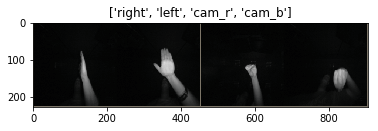

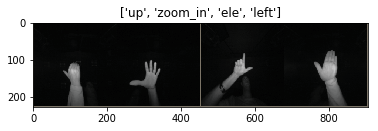

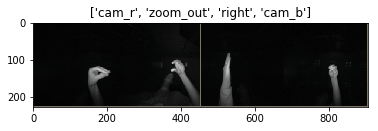

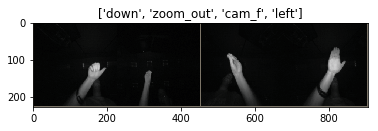

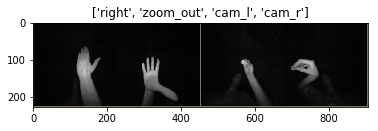

In [13]:
# Show some training images
def imshow(inp, title=None):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Plot grid for 5 rows
for i in range(5):
    # Get a batch of training data (4 per batch)
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid of training data
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])
    i += 1

### 3. Create model for transfer learning

In [14]:
Epochs = []
Training = []
Validation = []
Tr_loss = []
Valid_loss = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        Epochs.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # Get the inputs
                inputs, labels = data

                # Wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, obtain ouputs and compute loss
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward pass, compute gradient, update parameters only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'train':
                Training.append(epoch_acc*100)
                Tr_loss.append(epoch_loss)
            else:
                Validation.append(epoch_acc*100)
                Valid_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy and save the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "HCW_wts")
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 4. Train the model

#### 4.1 Test cycle 1: Initial run (lr=0.001, mo=0.9, decay=7)

In [15]:
# Instantiate model class and freeze weights of all layers
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Create final layer as a fully connected layer with inputs 512 and output 11.
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 11)
# Load previously saved weights from training
# model_conv.load_state_dict(torch.load("HCW_wts (91.75%)"))
# print(model_conv.fc)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optmized.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [73]:
model_conv.children

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=1)

In [ ]:
# Plot training, validation accuracy graph vs epoch runs
def plot_training(Epochs, Training, Validation):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Training, label='Training')
    plt.plot(Epochs, Validation, label='Validation')
    plt.title("SGD Training and Validation Accuracy, Lr=0.001, Mo=0.9, Decay=7", fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.ylim(0,100)
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Plot training, validation loss graph vs epoch runs
def plot_loss(Epochs, Tr_loss, Valid_loss):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Tr_loss, label='Training')
    plt.plot(Epochs, Valid_loss, label='Validation')
    plt.title("SGD Training and Validation Loss, Lr=0.001, Mo=0.9, Decay=7", fontsize=20)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
plot_training(Epochs, Training, Validation)

In [ ]:
plot_loss(Epochs, Tr_loss, Valid_loss)

In [ ]:
# Save model 
torch.save(model_conv, 'model_conv')

In [16]:
# Load model to resume or perform predictions
model_conv = torch.load('model_conv')

### 5. Analysis of predictions

In [17]:
import itertools

label = []
predictions = []
merged_probs = []
images = []

for i, data in enumerate(dataloaders['val']):
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
        
    outputs = model_conv(inputs)
    # Activation and prediction for each image 
    _, preds = torch.max(outputs.data, 1)
    
    # Extract labels into a list
    labels = labels.data.cpu().numpy()
    label.append(labels)
    merged_labels = np.array(list(itertools.chain(*label)))
    
    # Extract predictions into a list
    preds = preds.numpy()
    predictions.append(preds)
    merged_preds = np.array(list(itertools.chain(*predictions)))
                           
    # Extract probabilities into a list
    x = torch.nn.functional.softmax(outputs)
    probs = x.data.cpu().numpy()
    for batch in probs:
        merged_probs.append(max(batch))
    
    # Extract dataset of images in Tensor format
    inputs = inputs.data.cpu().numpy()
    images.append(inputs)
    merged_ds = np.array(list(itertools.chain(*images)))

In [18]:
# Returns indices of x random filtered values from list
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 6, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((merged_preds == merged_labels) == is_correct)

In [19]:
from os import listdir
from os.path import isfile, join

def load_img_id(ds, idx): return np.array(toimage(ds[idx]))

# Plot 8 rows by 5 images subplot
def plots(ims, figsize=(16,40), rows=8, titles=None, axis=1):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        ax = f.add_subplot(8,5,i+1)
        #ax.axis('Off')
        if titles is not None: ax.set_title("Prob:{:.4f}".format(titles[i], fontsize=12))
        if axis is not None: ax.set_xlabel("Pred:{}".format(class_names[axis[i]]), fontsize=12)
        plt.imshow(ims[i])

In [20]:
def plot_val_with_title(idxs, title):
    print(title)
    imgs = np.stack([load_img_id(merged_ds,x) for x in idxs])
    title_probs = [merged_probs[x] for x in idxs]
    title_preds = [merged_preds[x] for x in idxs]
    return plots(imgs, rows=1, titles=title_probs, axis=title_preds, figsize=(16,40))

In [21]:
# Returns up to 40 images for display
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*np.array(merged_probs)[idxs])[:40]]

def most_by_correct(y, is_correct): 
    mult = -1
    return most_by_mask(((merged_preds == merged_labels)==is_correct) & (merged_labels == y), mult)

Correctly classified (random)


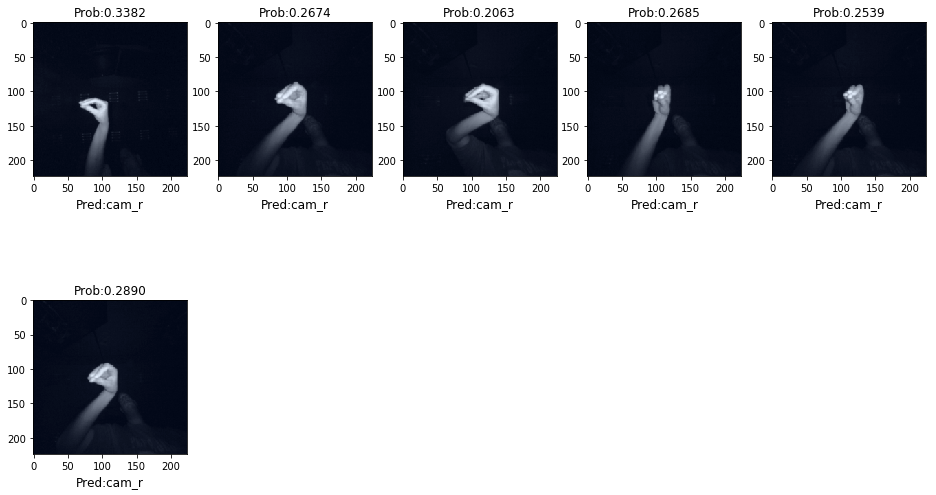

In [22]:
plot_val_with_title(rand_by_correct(True), "Correctly classified (random)")

Incorrectly classified (all)


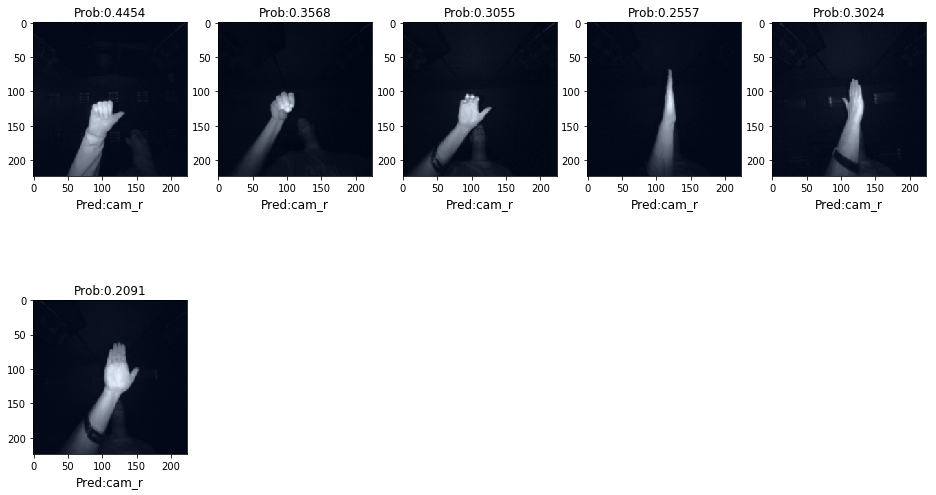

In [23]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified (all)")

In [25]:
np.count_nonzero((merged_preds == merged_labels)==True)

174

Correct cam_r (all)


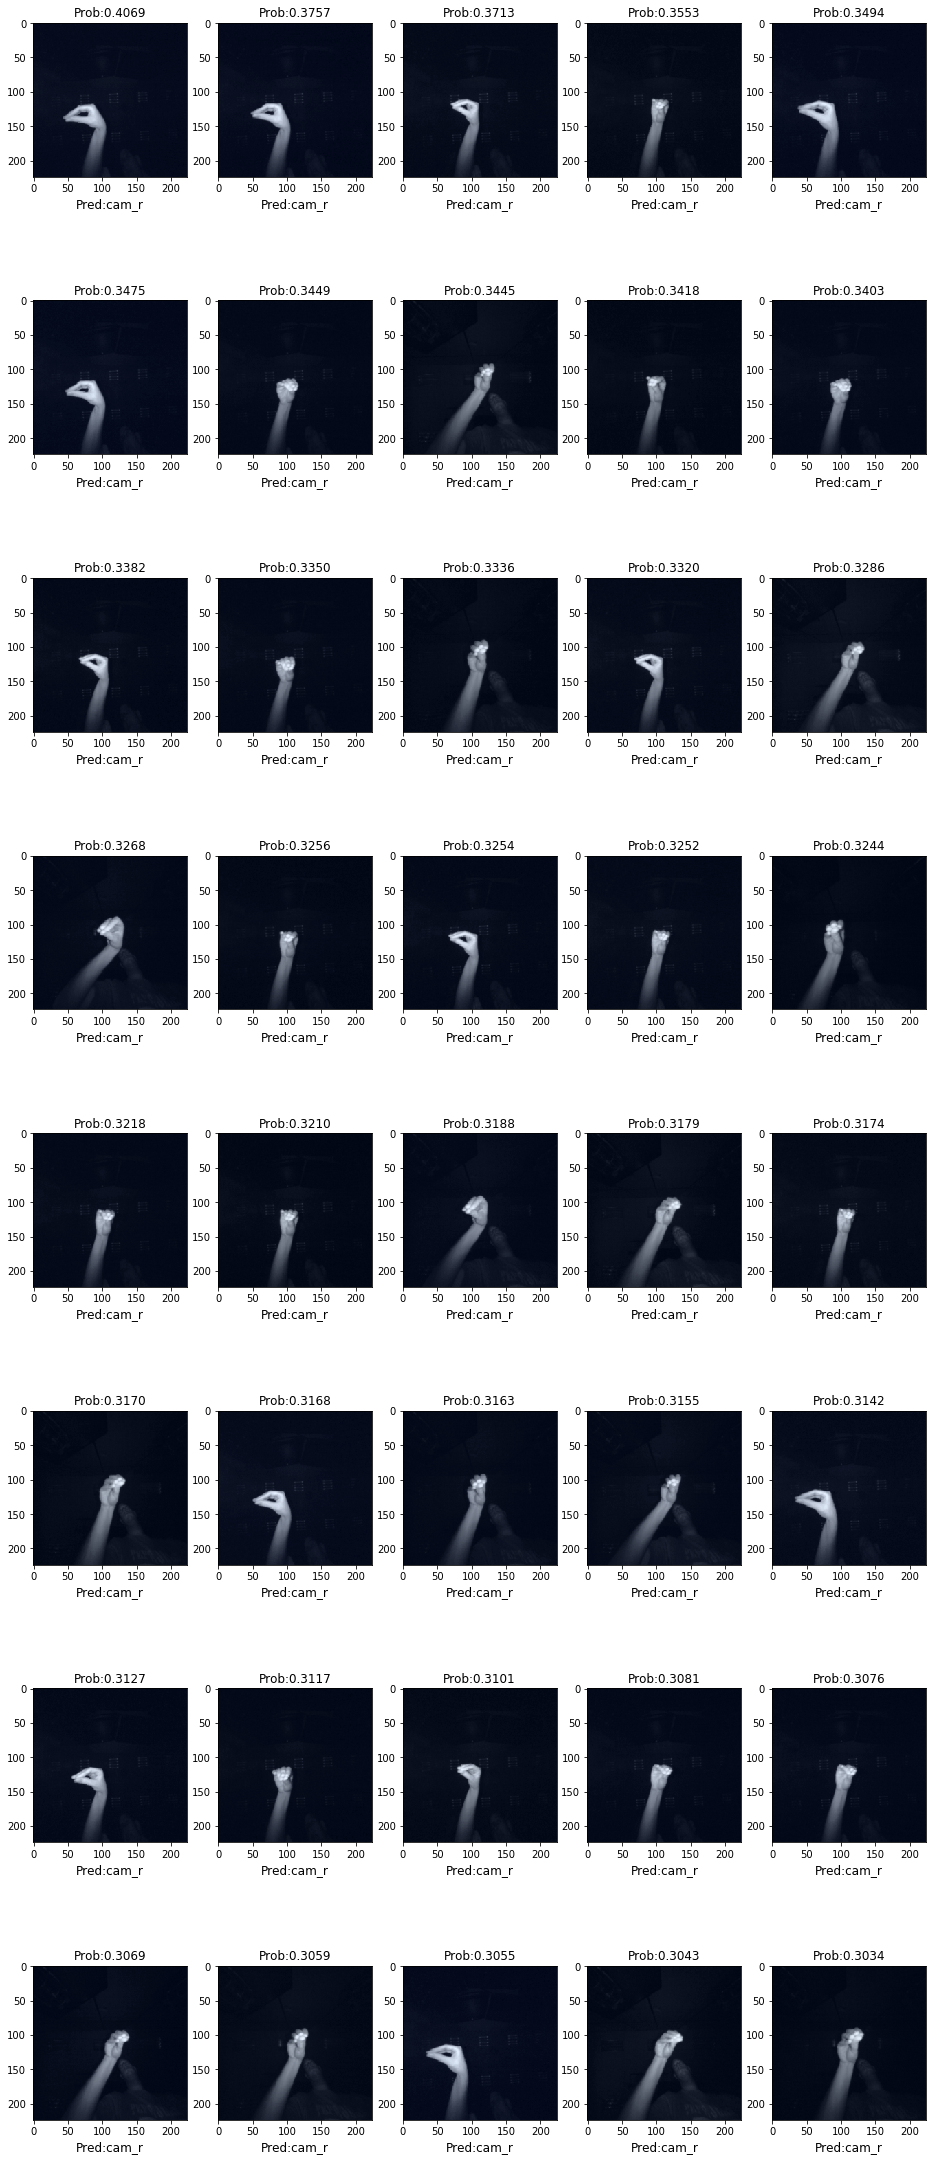

In [32]:
plot_val_with_title(most_by_correct(3, True), 'Correct cam_r (all)')

Incorrect cam_r (all)


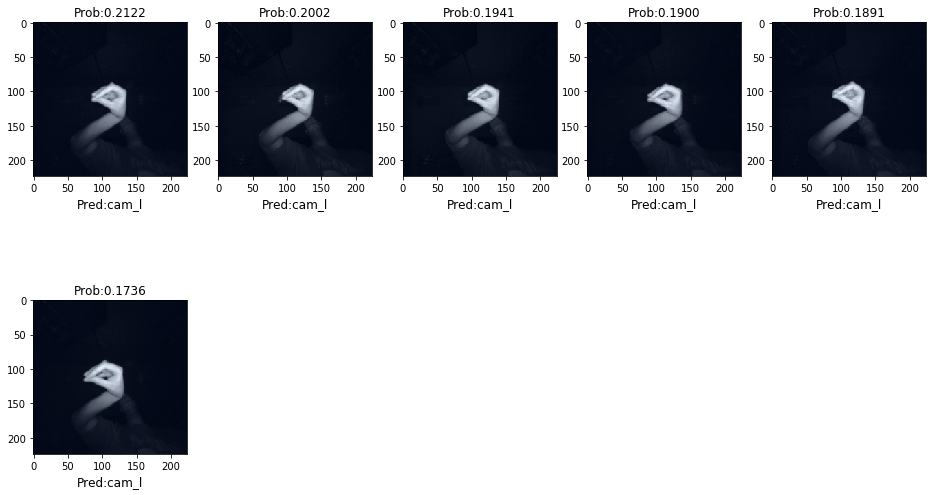

In [33]:
plot_val_with_title(most_by_correct(3, False), 'Incorrect cam_r (all)')

Most uncertain predictions


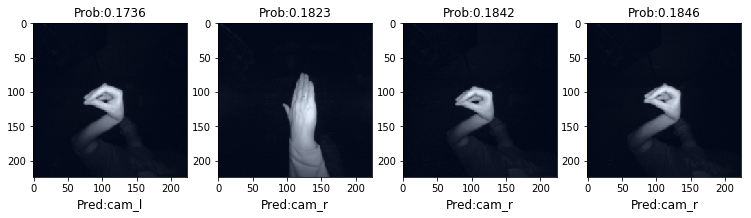

In [43]:
most_uncertain = np.argsort(np.array(merged_probs))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [47]:
camr_preds = (((merged_preds == merged_labels)==True) & (merged_labels == 3))
zoomin_preds = (((merged_preds == merged_labels)==True) & (merged_labels == 9))
zoomout_preds = (((merged_preds == merged_labels)==True) & (merged_labels == 10))

camr_acc = np.count_nonzero(camr_preds)/np.count_nonzero(merged_labels == 3) * 100 
zoomin_acc = np.count_nonzero(zoomin_preds)/np.count_nonzero(merged_labels == 9) * 100 
zoomout_acc = np.count_nonzero(zoomout_preds)/np.count_nonzero(merged_labels == 10) * 100 
                                                           
print("camr Acc:{:.2f}%\nzoomin Acc:{:.2f}%\nzoomout Acc:{:.2f}%".format(camr_acc, zoomin_acc, zoomout_acc))

camr Acc:96.67%
zoomin Acc:0.00%
zoomout Acc:0.00%


In [49]:
camr_preds = (((merged_preds == merged_labels)==True) & (merged_labels == 3)); camr_preds
np.count_nonzero(camr_preds)

174

In [50]:
np.count_nonzero(merged_labels == 3)

180

### 6. Understanding how the model makes its predictions

In [78]:
def load_image(path):
    image = Image.open(path).convert('RGB')
    return image

def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0))
    return image

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229,0.224,0.225]
)

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
])

In [79]:
def smooth_grad(input, label, sample=10, percent_noise=10):
    tensor_input = torch.from_numpy(np.array(input)).type(torch.FloatTensor) # input is now of shape (width, height, channel)
    final_grad = torch.zeros((1,3,224,224))
    for i in range(sample):
        temp_input = tensor_input
        # According to the paper, noise level corresponds to std dev/(xmax-xmin). Hence std dev = noise_percentage * (max-min)/100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100)*(tensor_input.max()-tensor_input.min()), size=temp_input.shape)).type(torch.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        temp_input = Variable(preprocess(temp_input).unsqueeze(0), requires_grad=True)
        
        output = model_conv.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
        
    grads = final_grad/sample
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = normalize(input)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)
    
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = (20,20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off')
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off')
    plt.title('SmoothGrad, Noise:' + str(percent_noise) + '%, ' + 'Samples: ' + str(sample))
    
    return grads

#### 6.1 Apply SmoothGrad

In [80]:
# Load most correct camr images
camr1_cor = load_image('./val/cam_r/frame_00_04_01_0007.png')

# Load most incorrect camr images
camr1_incor = load_image('./val/cam_r/frame_00_04_02_0010.png')

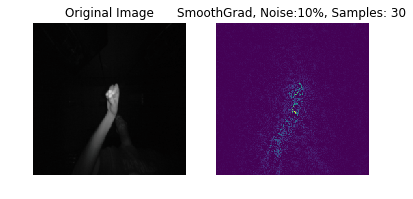

In [81]:
# Analyse correct doctors activations on last layer
camr1_cor_sg = smooth_grad(camr1_cor,3,30,10)